## CSE 5320 Neural Networks Project 1
### Josias Moukpe
### Report (Embedded Code)

Objective: GAN on Coco 

#### References
https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29
https://www.tensorflow.org/tutorials/generative/dcgan

In [40]:
# imports
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist #, gtzan #, coco

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report


import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [27]:

# check if GPU is available
numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)

Num GPUs Available:  1
/device:GPU:0
device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:03:00.0, compute capability: 6.1


GAN on MNIST 

In [28]:
# read mnist data
(train_images, train_labels), (_, _) = mnist.load_data()
# print shapes
print('x_train shape:', train_images.shape)
print('y_train shape:', train_labels.shape)


x_train shape: (60000, 28, 28)
y_train shape: (60000,)


In [29]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256


# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [30]:
# Build the generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
#   conv2DTranspose or deconvolution
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

noise: [[-0.43629444  2.013406    0.73521507 -1.529826    0.21628125 -1.3062788
  -0.36322945 -0.8749015  -0.72740823  0.7016211   0.01198502 -0.48587382
   2.126011   -0.10708132  0.2437601   0.66923994  0.3375026   0.9020442
   0.41883886 -0.39434505  1.6830645  -0.76322395 -0.3086918  -0.79206187
  -0.7017859   1.3211516  -0.36500096 -0.0367393   1.2889898   0.8260297
   0.18262623 -0.32736823  0.6522505   0.22028056  0.2116367   0.92632353
   1.0588938  -0.03655864  1.3381039  -0.01946522  0.83750695  1.4462225
   1.0016115  -0.68294007  0.0428092  -0.41284323 -0.5869538   1.2329211
  -0.7217481   0.2951805   0.880966   -1.7056367   0.69364744  1.259064
   0.28380728  0.40828824  0.6500068  -1.1626785  -1.081739    1.4474642
   0.9547737   0.38392374 -0.07155357 -1.318424    1.745192   -1.9613335
  -0.36544812 -0.10704651 -1.3161951  -0.437647    0.41283152 -0.82333136
   0.07340487 -0.761003    2.0420249   0.24407314 -0.78412014  0.6465451
   0.37999374 -0.88310814 -1.0613952  -1.

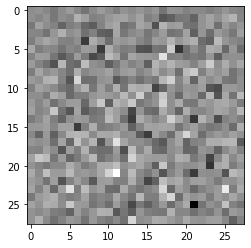

In [31]:
# create image from noise with untrained generator model
generator = make_generator_model()
# sampling noise from a normal distribution
noise = tf.random.normal([1, 100])
# print the noise
print(f"noise: {noise}")
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [32]:
# build the discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [33]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00067889]], shape=(1, 1), dtype=float32)


In [34]:
# define the loss and optimizers
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [35]:
# to save the checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [44]:
# define the training loop
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [37]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('./gens/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [38]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

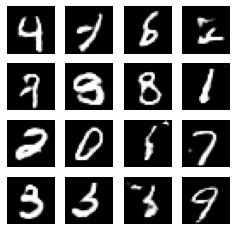

In [46]:
# train the models (important that generator and discriminator don't overpower each other)
EPOCHS = 200
train(train_dataset, EPOCHS)

In [24]:
# to restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

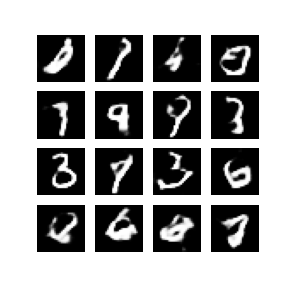

In [42]:
# create and display a single image
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('./gens/image_at_epoch_{:04d}.png'.format(epoch_no))


display_image(EPOCHS)

C:\Users\the_3\AppData\Local\Temp\ipykernel_13252\2958492857.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\the_3\AppData\Local\Temp\ipykernel_13252\2958492857.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



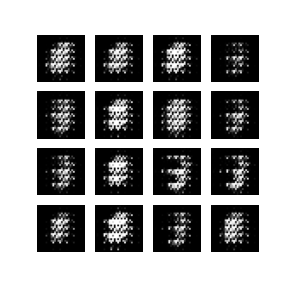

In [43]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

GAN on Coco now

In [ ]:
# download and load the coco dataset
